In [101]:
import numpy as np
import tensorflow as tf
import cv2
import os
import glob
import matplotlib.pyplot as plt

##### Read training images and bounding box annotations

In [102]:
### Read bounding box annotations - training set
data_dir = "../wider_face/data"
with open(os.path.join(data_dir, "wider_face_split/wider_face_train_bbx_gt.txt"), "r") as file: 
    bbox_anno = [line.rstrip("\n, ") for line in file.readlines()]

In [103]:
### Create a dictionary such that it contains image_name:respective_annotations 
img_indices = []
n_bbxes = []
for i in range(len(bbox_anno)):
    if bbox_anno[i].endswith((".jpg", ".jpeg", ".png")):
        img_indices.append(i)
        n_bbxes.append(int(bbox_anno[i+1]))
train_annotations = {}
for idx,n in list(zip(img_indices, n_bbxes)):
    img_name = bbox_anno[idx]
    res_annot = bbox_anno[idx+2 : idx+2+n]
    ### Remove blur, expression, illumination, invalid, occlusion and pose details. Keep x1, y1, w and h.
    res_annot = [" ".join(annot.split()[:4]) for annot in res_annot]
    train_annotations[img_name] = res_annot

##### Display training images and bounding boxes

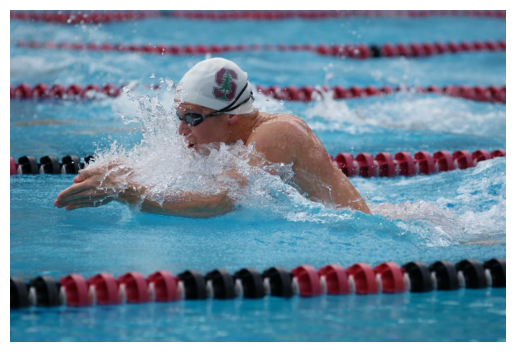

In [104]:
### Display random images from the training set
rand_n = np.random.randint(len(train_annotations))
img_name, bbxs = list(train_annotations.items())[rand_n]
bgr = cv2.imread(os.path.join(data_dir, "WIDER_train/images", img_name))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.axis("off")
plt.show()

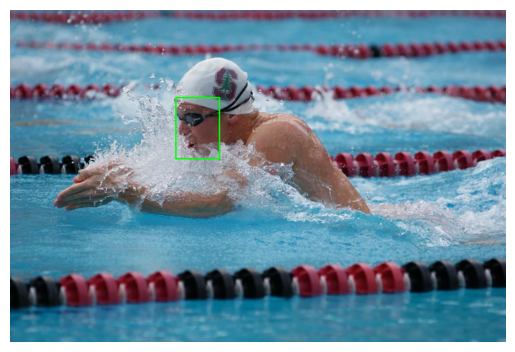

In [105]:
### Display bounding boxes
for annot in bbxs:
    x, y, w, h = [int(pt) for pt in annot.split()]
    cv2.rectangle(rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.axis("off")
plt.show()

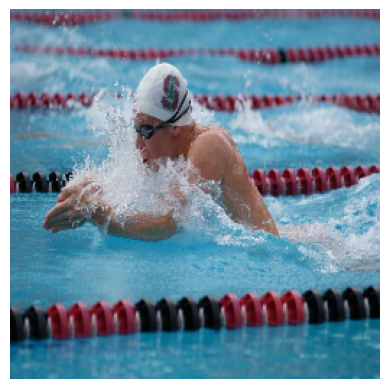

In [106]:
### Reshape images
OUTPUT_SHAPE = (256, 256)
bgr_ = cv2.imread(os.path.join(data_dir, "WIDER_train/images", img_name))
rgb_ = cv2.cvtColor(bgr_, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(rgb_, OUTPUT_SHAPE)
plt.imshow(resized_image)
plt.axis("off")
plt.show()

In [107]:
### Rescale bounding box annotations
def scale_bbxs(bbxs, org_img_shape, out_img_shape):
    org_height, org_width = org_img_shape
    new_height, new_width = out_img_shape
    scale_x = new_width / org_width
    scale_y = new_height / org_height
    scaled_bbxs = []
    for bbx in bbxs:
        x, y, w, h = [int(pt) for pt in bbx.split()]
        scaled_bbx = list(map(round, [scale_x * x, scale_y * y, scale_x * w, scale_y * h]))
        scaled_bbxs.append(scaled_bbx)
    return scaled_bbxs

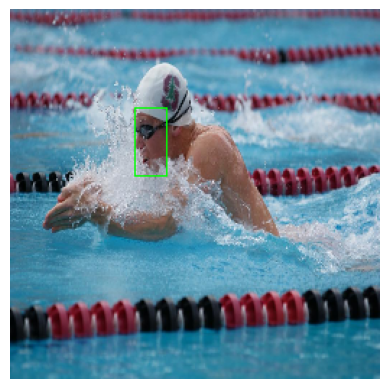

In [108]:
### Display rescaled bounding boxes
scaled_bbx = scale_bbxs(bbxs, rgb.shape[:2], OUTPUT_SHAPE)
for bbx in scaled_bbx:
    x, y, w, h = bbx
    cv2.rectangle(resized_image, (x, y), (x+w, y+h), (0, 255, 0), 1)
plt.imshow(resized_image, )
plt.axis("off")
plt.show()

##### Preprocessing

In [109]:
BATCH_SIZE = 32
### Define generator
def generator(data_path, image_bbxs, batch_size, output_shape):
    num_samples = len(image_bbxs)
    indices = np.arange(num_samples)
    image_names = list(image_bbxs.keys())
    bbxs = list(image_bbxs.values())
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        batch_images = []
        for idx in batch_indices:
            image_path = os.path.join(data_path, image_names[idx])
            image = cv2.resize(cv2.imread(image_path), output_shape)
            batch_images.append(image)
            ####
            # todo: rescale bounding boxes
            bbx = bbxs[idx]
            batch_labels.append(bbx)
            ####
        yield (np.stack(batch_images), batch_labels)

In [73]:
g = generator(os.path.join(data_dir, "WIDER_train/images"), train_annotations, batch_size=BATCH_SIZE, output_shape=OUTPUT_SHAPE)